## Deep Convolutional Generative Adversarial Neural Network [DCGAN]
    It is a class of CNNs, that have certain architectural constraints, and demonstrate that they are a strong candidate for unsupervised learning.

> This notebook explains generation of the Artificial Anime Faces based upon the user provided Random Latent Vectors. 

### 1. Dataset Creation and Visualization

In [1]:
"""Import Packages"""

import os 
import cv2
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image
from tqdm.notebook import tqdm
from torchview import draw_graph # Ref and credits: https://github.com/mert-kurttutan/torchview for visualizing model graph.
import numpy as np
%matplotlib inline

In [2]:
"""Images Directory"""
# Dataset Ref: https://www.kaggle.com/datasets/splcher/animefacedataset

Root_Directory = 'archive (2)'
Directory = os.path.join(Root_Directory, ''.join(os.listdir(Root_Directory)))
Anime_Images = os.listdir(Directory)
len(Anime_Images)

63565

In [3]:
"""Parameters"""

image_size = (64, 64)
batch_size = 512
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [4]:
"""Creating DataLoader from dataset with transformations."""

dataset = ImageFolder(Root_Directory, transform = T.Compose([
                      T.Resize(image_size), 
                      T.CenterCrop(image_size),
                      T.ToTensor(),
                      T.Normalize(*stats)]))
Train_Dl = DataLoader(dataset, batch_size, shuffle = True, num_workers = 4, pin_memory = True)

In [5]:
"""Functions to show images in batch."""

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.cpu().detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

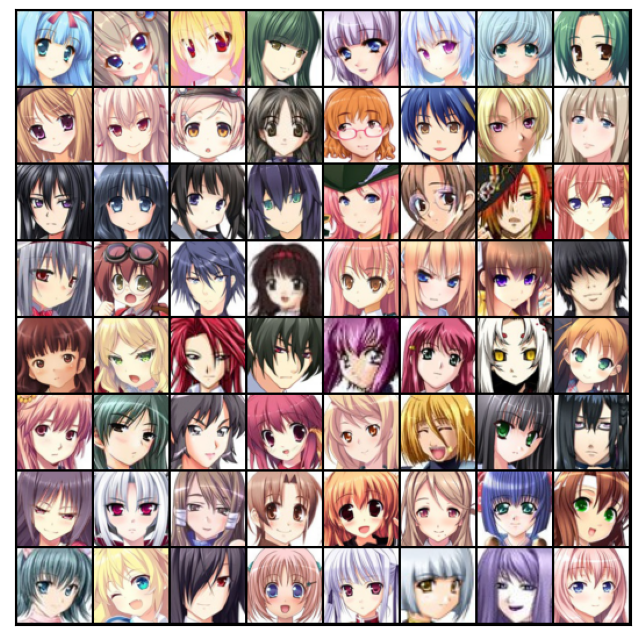

In [6]:
show_batch(Train_Dl)

In [7]:
def get_default_device():
    """Use GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move Tensors to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a Dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [8]:
"""Check for the device."""
device = get_default_device()
device

device(type='cuda')

In [9]:
"""Moving DataLoader to the respective Device."""
Train_Dl = DeviceDataLoader(Train_Dl, device)
Train_Dl

### 2. Model

In [10]:
"""Function for Discriminator Convolutoinal Block."""

def conv_block(in_channels, out_channels):
    block = [nn.Conv2d(in_channels, out_channels, kernel_size= (4, 4), stride = (2, 2), padding = 1, bias = False),
                          nn.BatchNorm2d(out_channels),
                          nn.LeakyReLU(0.2, inplace = True)]
    return block

In [11]:
"""Function for Generator Convolutoinal Block."""

def conv_tr_block(in_channels, out_channels):
    layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size = (4, 4), stride = (2, 2), padding = 1, bias = False),
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(True)]
    return layers

In [12]:
"""Function for Weight Intialization of Generator."""

def weight_initialize_gen(layer):
            type_ = type(layer)
            if type_ == nn.ConvTranspose2d:
                nn.init.normal_(layer.weight.data, 0.0, 0.02)
            elif type_ == nn.BatchNorm2d:
                nn.init.normal_(layer.weight.data, 1.0, 0.1)
                nn.init.constant_(layer.bias, 0)

In [13]:
"""Function for Weight Intialization of Discriminator."""

def weight_initialize_dis(layer):
            type_ = type(layer)
            if type_ == nn.Conv2d:
                nn.init.normal_(layer.weight.data, 0.0, 0.02)
            elif type_ == nn.BatchNorm2d:
                nn.init.normal_(layer.weight.data, 1.0, 0.1)
                nn.init.constant_(layer.bias, 0)

In [14]:
"""Discriminator Class"""

class Discriminator(nn.Module):

    def __init__(self):
        super().__init__()
        self.discriminator = nn.Sequential(*conv_block(3, 64), # IN(3, 64, 64) OUT(64, 32, 32) 
                              *conv_block(64, 128), # IN(64, 32, 32) OUT(128, 16, 16)
                              *conv_block(128, 256), # IN(128, 16, 16) OUT(256, 8, 8)
                              nn.Dropout(0.2),
                              *conv_block(256, 512), # IN(256, 8, 8) OUT(512, 4, 4)
                              nn.Dropout(0.2),
                              nn.Conv2d(512, 1, kernel_size = (4, 4), stride = (1, 1), padding = 0, bias = False), # IN(512, 4, 4) OUT(1, 1, 1)
                              nn.Flatten(),
                              nn.Sigmoid())
        
    def forward(self, x):
        out = self.discriminator(x)
        return out
    

In [15]:
"""Generator Class"""

class Generator(nn.Module):

    def __init__(self, latent_dim):
        super().__init__()
        self.generator = nn.Sequential(
                            nn.ConvTranspose2d(1024, 512, kernel_size = (1, 1), stride = (1, 1), padding = 0, bias = False), # IN(1024, 4, 4) OUT(512, 4, 4)
                            nn.BatchNorm2d(512), 
                            nn.ReLU(True),

                            *conv_tr_block(512, 256), # IN(512, 4, 4) OUT(256, 8, 8)
                            *conv_tr_block(256, 128), # IN(256, 8, 8) OUT(128, 16, 16)
                            *conv_tr_block(128, 64), # IN(128 16, 16) OUT(64, 32, 32)
                            nn.ConvTranspose2d(64, 3, kernel_size = (4, 4), stride = (2, 2), padding = 1, bias = False), # IN(64, 32, 32) OUT(3, 64, 64)
                            nn.Tanh())
        self.img_size_half = image_size[0] // 2
        self.linear = nn.Linear(latent_dim, 512 * self.img_size_half, bias = False)
    
    def forward(self, x):
        out = self.linear(x)
        #print(out.size())
        shape = (out.size(0) * out.size(1)) // (out.size(0) * 1024)
        out = out.view(out.size(0), 1024, int(np.sqrt(shape)), int(np.sqrt(shape)))
        #print(out.size())
        out = self.generator(out)
        return out

In [16]:
latent_dim = 128 # Latent Vector Dimension
discriminator = Discriminator()
generator = Generator(latent_dim)


(process:65152): Pango-WARNING **: 21:12:27.476: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


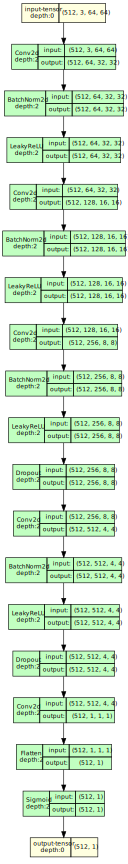

In [ ]:
"""Graph of Discriminator."""
model_graph = draw_graph(discriminator, input_size = (batch_size, 3, 64, 64), device = 'cpu')
model_graph.visual_graph


(process:57628): Pango-WARNING **: 21:12:32.526: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


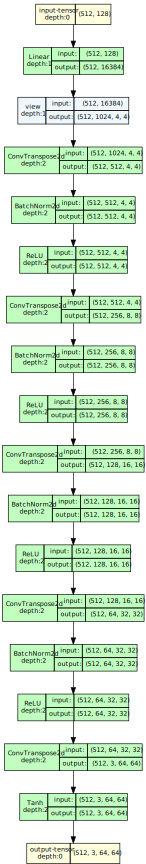

In [ ]:
"""Graph of Generator."""
model_graph = draw_graph(generator, input_size = (batch_size, latent_dim), device = 'cpu')
model_graph.visual_graph

In [19]:
"""Apply Weights and Transfer to Device."""
discriminator.apply(weight_initialize_dis)
to_device(discriminator, device)

Discriminator(
  (discriminator): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout(p=0.2, inplace=False)
    (10): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.2, inp

In [20]:
"""Apply Weights and Transfer to Device."""
generator.apply(weight_initialize_gen)
to_device(generator, device)

Generator(
  (generator): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()


torch.Size([512, 3, 64, 64])


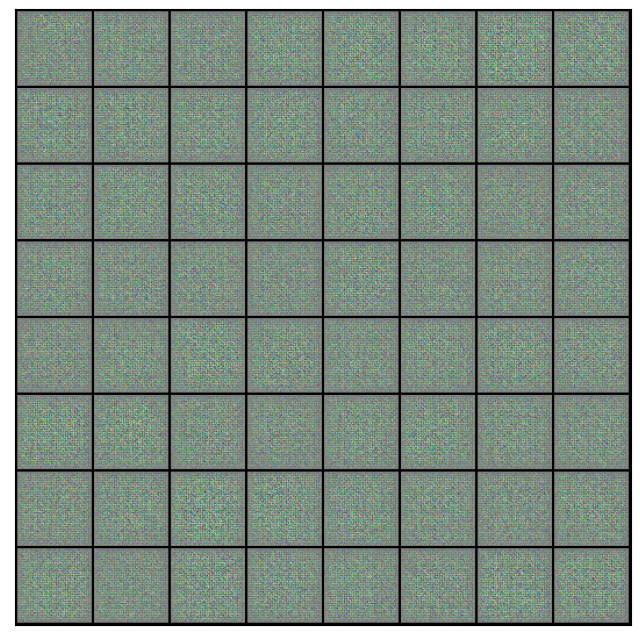

In [ ]:
xb = torch.randn(batch_size, latent_dim, device = device) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

### 3. Train Functions

In [22]:
"""Train Function for Discriminator."""

def Train_Discriminator(true_images, Opt_D):
    Opt_D.zero_grad()

    """True Dataset Prediction"""
    true_pred = discriminator(true_images)
    true_targets = torch.ones(true_images.size(0), 1, device = device)
    true_loss = F.binary_cross_entropy(true_pred, true_targets)
    true_score = torch.mean(true_pred).item()

    """Fake Dataset Generation"""
    fake_data = torch.randn(batch_size, latent_dim, device = device)
    fake_images = generator(fake_data)

    """Fake Dataset Prediction"""
    fake_pred = discriminator(fake_images)
    fake_targets = torch.zeros(fake_images.size(0), 1, device = device)
    fake_loss = F.binary_cross_entropy(fake_pred, fake_targets)
    fake_score = torch.mean(fake_pred).item()

    """Loss Computation of both True and Fake"""
    loss = true_loss + fake_loss
    loss.backward()
    Opt_D.step()

    return loss.item(), true_score, fake_score


In [23]:
"""Train Function for Generator."""

def Train_Generator(Opt_G):
    Opt_G.zero_grad()

    """Fake Dataset Generation"""
    fake_data = torch.randn(batch_size, latent_dim, device = device)
    fake_images = generator(fake_data)

    """Fake Dataset Prediction - Making the Discriminator to predict this Adversial Data as True Image, 
       so that Generator updates itself in improving the quality of generation.
    """
    pred = discriminator(fake_images)
    targets = torch.ones(fake_images.size(0), 1, device = device)
    loss = F.binary_cross_entropy(pred, targets)
    fake_score = torch.mean(pred).item()

    loss.backward()
    Opt_G.step()

    return loss.item()

In [24]:
sample_dir = 'generated_new'
os.makedirs(sample_dir, exist_ok=True)

In [25]:
"""Function to save generated images of the fixed latent during training."""
def save_samples(index, latent_tensors, show = True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [26]:
fixed_latent = torch.randn(64, latent_dim, device = device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


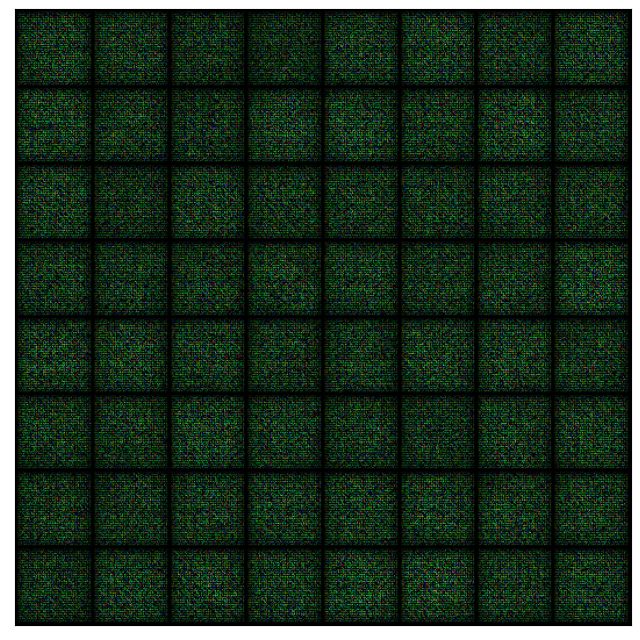

In [ ]:
"""Generated Image before Training."""
save_samples(0, fixed_latent)

### 4. Model Training

In [27]:
"""Fit Function"""

def fit(epochs, lr, start_idx = 1):
    torch.cuda.empty_cache()
    
    """Losses & scores"""
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    """Create optimizers"""
    opt_d = torch.optim.Adam(discriminator.parameters(), lr = lr, betas = (0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr = lr, betas = (0.5, 0.999))
    
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(Train_Dl):
            # Train discriminator
            loss_d, real_score, fake_score = Train_Discriminator(real_images, opt_d)
            # Train generator
            loss_g = Train_Generator(opt_g)
            
        """Record losses & scores"""
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        """Log losses & scores (last batch)"""
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        """Save generated images"""
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [28]:
lr = 0.0001
epochs = 100

In [29]:
"""Kickstart of Train"""
history = fit(epochs, lr)

  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [1/100], loss_g: 2.2990, loss_d: 0.4293, real_score: 0.7845, fake_score: 0.1064
Saving generated-images-0001.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 3.2873, loss_d: 0.4030, real_score: 0.8907, fake_score: 0.2075
Saving generated-images-0002.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 1.1667, loss_d: 1.5426, real_score: 0.3185, fake_score: 0.0076
Saving generated-images-0003.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 3.8228, loss_d: 0.3676, real_score: 0.9576, fake_score: 0.2367
Saving generated-images-0004.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 2.8577, loss_d: 0.9284, real_score: 0.8971, fake_score: 0.4680
Saving generated-images-0005.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 3.6268, loss_d: 0.2404, real_score: 0.9200, fake_score: 0.1223
Saving generated-images-0006.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 3.2686, loss_d: 0.2444, real_score: 0.8979, fake_score: 0.1015
Saving generated-images-0007.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 3.0730, loss_d: 0.2775, real_score: 0.8909, fake_score: 0.1221
Saving generated-images-0008.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 3.0402, loss_d: 0.6313, real_score: 0.6195, fake_score: 0.0222
Saving generated-images-0009.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 1.0654, loss_d: 0.5622, real_score: 0.6837, fake_score: 0.0491
Saving generated-images-0010.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 3.3483, loss_d: 0.2370, real_score: 0.9098, fake_score: 0.1132
Saving generated-images-0011.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 2.9258, loss_d: 0.2996, real_score: 0.8059, fake_score: 0.0449
Saving generated-images-0012.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 3.9492, loss_d: 0.3949, real_score: 0.9173, fake_score: 0.2166
Saving generated-images-0013.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 2.8572, loss_d: 0.3014, real_score: 0.8256, fake_score: 0.0765
Saving generated-images-0014.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 2.8885, loss_d: 0.3576, real_score: 0.8606, fake_score: 0.1351
Saving generated-images-0015.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 3.4544, loss_d: 0.2380, real_score: 0.9181, fake_score: 0.1179
Saving generated-images-0016.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 3.0857, loss_d: 0.7818, real_score: 0.9601, fake_score: 0.4456
Saving generated-images-0017.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 3.5491, loss_d: 0.2940, real_score: 0.9067, fake_score: 0.1457
Saving generated-images-0018.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 1.6313, loss_d: 0.9496, real_score: 0.4885, fake_score: 0.0155
Saving generated-images-0019.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 1.6894, loss_d: 0.3499, real_score: 0.7792, fake_score: 0.0488
Saving generated-images-0020.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 2.6391, loss_d: 0.2428, real_score: 0.8839, fake_score: 0.0904
Saving generated-images-0021.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 2.8896, loss_d: 0.3668, real_score: 0.8898, fake_score: 0.1832
Saving generated-images-0022.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 5.0846, loss_d: 0.5002, real_score: 0.9813, fake_score: 0.3161
Saving generated-images-0023.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 3.9331, loss_d: 0.3264, real_score: 0.9600, fake_score: 0.2101
Saving generated-images-0024.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 4.7703, loss_d: 0.4905, real_score: 0.9369, fake_score: 0.2817
Saving generated-images-0025.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 2.7653, loss_d: 0.2886, real_score: 0.8917, fake_score: 0.1251
Saving generated-images-0026.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 1.9002, loss_d: 0.7321, real_score: 0.6899, fake_score: 0.2218
Saving generated-images-0027.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 1.4887, loss_d: 0.6100, real_score: 0.7791, fake_score: 0.2228
Saving generated-images-0028.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 2.2501, loss_d: 1.6765, real_score: 0.8394, fake_score: 0.6643
Saving generated-images-0029.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 3.3305, loss_d: 0.3093, real_score: 0.9312, fake_score: 0.1788
Saving generated-images-0030.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 2.8775, loss_d: 0.4193, real_score: 0.7574, fake_score: 0.0682
Saving generated-images-0031.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 3.1056, loss_d: 0.3216, real_score: 0.8502, fake_score: 0.1172
Saving generated-images-0032.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 4.7124, loss_d: 0.4371, real_score: 0.9770, fake_score: 0.2796
Saving generated-images-0033.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 1.4807, loss_d: 0.3728, real_score: 0.7782, fake_score: 0.0450
Saving generated-images-0034.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 3.7553, loss_d: 0.2266, real_score: 0.9214, fake_score: 0.1114
Saving generated-images-0035.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 1.9349, loss_d: 0.4207, real_score: 0.7899, fake_score: 0.1077
Saving generated-images-0036.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 1.3702, loss_d: 0.5529, real_score: 0.6769, fake_score: 0.0305
Saving generated-images-0037.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 1.9588, loss_d: 0.4718, real_score: 0.7689, fake_score: 0.1181
Saving generated-images-0038.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 2.4257, loss_d: 0.5440, real_score: 0.7648, fake_score: 0.1697
Saving generated-images-0039.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 5.1744, loss_d: 0.8057, real_score: 0.9740, fake_score: 0.4448
Saving generated-images-0040.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 3.8489, loss_d: 0.2039, real_score: 0.8951, fake_score: 0.0699
Saving generated-images-0041.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 4.5491, loss_d: 0.2627, real_score: 0.9744, fake_score: 0.1787
Saving generated-images-0042.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 1.0686, loss_d: 0.3839, real_score: 0.7531, fake_score: 0.0386
Saving generated-images-0043.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 3.3819, loss_d: 0.1628, real_score: 0.9080, fake_score: 0.0506
Saving generated-images-0044.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 2.2948, loss_d: 0.2404, real_score: 0.8590, fake_score: 0.0563
Saving generated-images-0045.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 2.6738, loss_d: 0.4564, real_score: 0.7962, fake_score: 0.1321
Saving generated-images-0046.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 4.7701, loss_d: 0.3796, real_score: 0.9602, fake_score: 0.2411
Saving generated-images-0047.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 1.2206, loss_d: 0.7633, real_score: 0.5766, fake_score: 0.0181
Saving generated-images-0048.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 4.4103, loss_d: 0.2696, real_score: 0.9322, fake_score: 0.1499
Saving generated-images-0049.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 0.3732, loss_d: 1.6586, real_score: 0.2832, fake_score: 0.0069
Saving generated-images-0050.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 5.4337, loss_d: 0.3432, real_score: 0.9725, fake_score: 0.2249
Saving generated-images-0051.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 2.7799, loss_d: 0.4958, real_score: 0.8428, fake_score: 0.2011
Saving generated-images-0052.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 4.7736, loss_d: 0.5723, real_score: 0.9651, fake_score: 0.3413
Saving generated-images-0053.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 1.5251, loss_d: 0.4591, real_score: 0.7121, fake_score: 0.0444
Saving generated-images-0054.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 1.2303, loss_d: 0.9334, real_score: 0.5074, fake_score: 0.0308
Saving generated-images-0055.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 2.4848, loss_d: 0.4122, real_score: 0.7782, fake_score: 0.0899
Saving generated-images-0056.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 1.9808, loss_d: 0.2754, real_score: 0.8170, fake_score: 0.0370
Saving generated-images-0057.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 2.7030, loss_d: 0.2625, real_score: 0.8400, fake_score: 0.0554
Saving generated-images-0058.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 2.7369, loss_d: 0.2330, real_score: 0.8790, fake_score: 0.0683
Saving generated-images-0059.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 3.3288, loss_d: 0.5214, real_score: 0.8351, fake_score: 0.2234
Saving generated-images-0060.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 2.8693, loss_d: 0.2494, real_score: 0.8521, fake_score: 0.0474
Saving generated-images-0061.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 3.5034, loss_d: 0.2375, real_score: 0.8932, fake_score: 0.0917
Saving generated-images-0062.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 2.1509, loss_d: 0.6998, real_score: 0.7804, fake_score: 0.2362
Saving generated-images-0063.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 2.5953, loss_d: 0.2773, real_score: 0.8478, fake_score: 0.0642
Saving generated-images-0064.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 3.7933, loss_d: 0.2918, real_score: 0.9558, fake_score: 0.1867
Saving generated-images-0065.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 2.5532, loss_d: 0.2983, real_score: 0.8895, fake_score: 0.1170
Saving generated-images-0066.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 1.8408, loss_d: 1.0093, real_score: 0.6326, fake_score: 0.2711
Saving generated-images-0067.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 4.3130, loss_d: 0.1815, real_score: 0.9505, fake_score: 0.1050
Saving generated-images-0068.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 1.6505, loss_d: 0.4483, real_score: 0.7030, fake_score: 0.0210
Saving generated-images-0069.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 4.4228, loss_d: 0.5154, real_score: 0.9551, fake_score: 0.3062
Saving generated-images-0070.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 3.6264, loss_d: 0.2503, real_score: 0.9230, fake_score: 0.1276
Saving generated-images-0071.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 1.8879, loss_d: 0.8615, real_score: 0.6667, fake_score: 0.2621
Saving generated-images-0072.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 3.7652, loss_d: 0.2832, real_score: 0.8987, fake_score: 0.1281
Saving generated-images-0073.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 4.2366, loss_d: 0.3278, real_score: 0.9003, fake_score: 0.1587
Saving generated-images-0074.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 3.9553, loss_d: 0.4817, real_score: 0.9262, fake_score: 0.2712
Saving generated-images-0075.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 3.8284, loss_d: 0.1433, real_score: 0.9375, fake_score: 0.0654
Saving generated-images-0076.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 1.3357, loss_d: 1.9563, real_score: 0.2563, fake_score: 0.0242
Saving generated-images-0077.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 3.4362, loss_d: 0.2396, real_score: 0.9379, fake_score: 0.1295
Saving generated-images-0078.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 2.3794, loss_d: 0.6257, real_score: 0.6377, fake_score: 0.0164
Saving generated-images-0079.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 0.9778, loss_d: 0.5813, real_score: 0.6292, fake_score: 0.0129
Saving generated-images-0080.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 4.2026, loss_d: 0.7964, real_score: 0.9766, fake_score: 0.4427
Saving generated-images-0081.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 4.3077, loss_d: 0.1591, real_score: 0.9323, fake_score: 0.0649
Saving generated-images-0082.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 2.2510, loss_d: 0.8546, real_score: 0.7237, fake_score: 0.3109
Saving generated-images-0083.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 2.9416, loss_d: 0.3330, real_score: 0.7894, fake_score: 0.0189
Saving generated-images-0084.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 0.2433, loss_d: 2.0345, real_score: 0.2244, fake_score: 0.0044
Saving generated-images-0085.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [86/100], loss_g: 5.1152, loss_d: 0.1972, real_score: 0.9653, fake_score: 0.1254
Saving generated-images-0086.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [87/100], loss_g: 3.4404, loss_d: 0.2054, real_score: 0.8773, fake_score: 0.0341
Saving generated-images-0087.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [88/100], loss_g: 4.1108, loss_d: 0.1557, real_score: 0.9343, fake_score: 0.0675
Saving generated-images-0088.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [89/100], loss_g: 3.5932, loss_d: 0.6179, real_score: 0.8790, fake_score: 0.2948
Saving generated-images-0089.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [90/100], loss_g: 2.5716, loss_d: 0.9462, real_score: 0.8601, fake_score: 0.4463
Saving generated-images-0090.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [91/100], loss_g: 1.0771, loss_d: 2.3844, real_score: 0.1780, fake_score: 0.0011
Saving generated-images-0091.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [92/100], loss_g: 1.6786, loss_d: 0.6871, real_score: 0.7885, fake_score: 0.2626
Saving generated-images-0092.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [93/100], loss_g: 5.0772, loss_d: 0.2555, real_score: 0.9700, fake_score: 0.1632
Saving generated-images-0093.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [94/100], loss_g: 6.0225, loss_d: 0.2550, real_score: 0.9842, fake_score: 0.1772
Saving generated-images-0094.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [95/100], loss_g: 4.4437, loss_d: 0.1852, real_score: 0.9511, fake_score: 0.1020
Saving generated-images-0095.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [96/100], loss_g: 2.8622, loss_d: 0.3989, real_score: 0.7428, fake_score: 0.0318
Saving generated-images-0096.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [97/100], loss_g: 3.8588, loss_d: 0.1353, real_score: 0.9164, fake_score: 0.0332
Saving generated-images-0097.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [98/100], loss_g: 5.5514, loss_d: 1.7331, real_score: 0.9852, fake_score: 0.7154
Saving generated-images-0098.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [99/100], loss_g: 4.2542, loss_d: 0.2302, real_score: 0.8725, fake_score: 0.0615
Saving generated-images-0099.png


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch [100/100], loss_g: 4.5082, loss_d: 0.1071, real_score: 0.9565, fake_score: 0.0513
Saving generated-images-0100.png


In [30]:
"""Save the model checkpoints.""" 
torch.save(generator.state_dict(), 'G_anime.pth')
torch.save(discriminator.state_dict(), 'D_anime.pth')

### 5. Visualization of loss and scores

In [31]:
losses_g, losses_d, real_scores, fake_scores = history

In [44]:
sample_dir

'generated_new'

In [32]:
"""Create Video for Generated Images."""

vid_fname = 'gans_bitmoji_faces_new.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 12, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

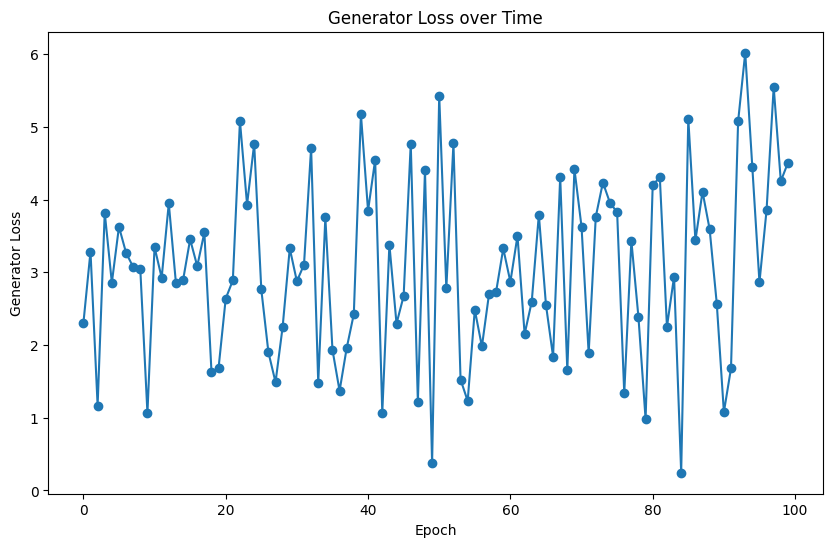

In [33]:
x = range(len(losses_g))

plt.figure(figsize=(10,6))
plt.plot(x, losses_g ,'-')
plt.scatter(x, losses_g)
plt.xlabel('Epoch')
plt.ylabel('Generator Loss')
plt.title('Generator Loss over Time')
plt.show()

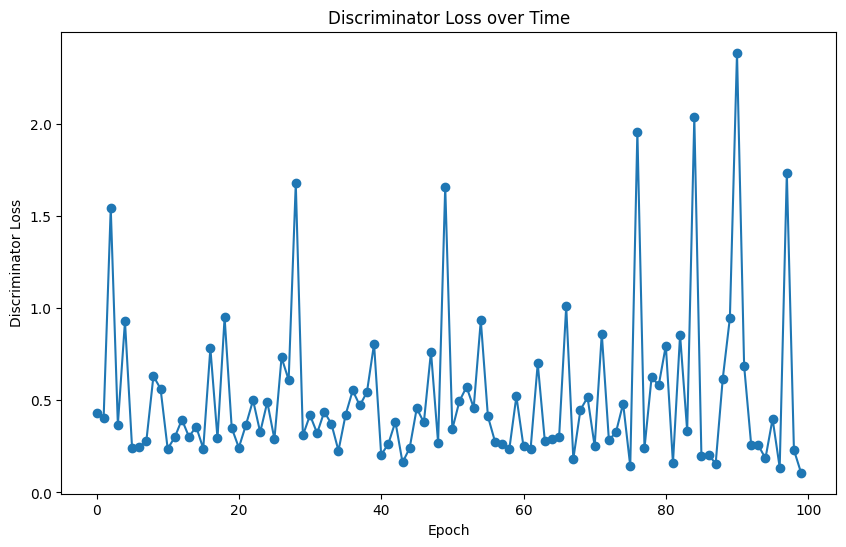

In [34]:
x = range(len(losses_d))

plt.figure(figsize=(10,6))
plt.plot(x, losses_d ,'-')
plt.scatter(x, losses_d)
plt.xlabel('Epoch')
plt.ylabel('Discriminator Loss')
plt.title('Discriminator Loss over Time')
plt.show()

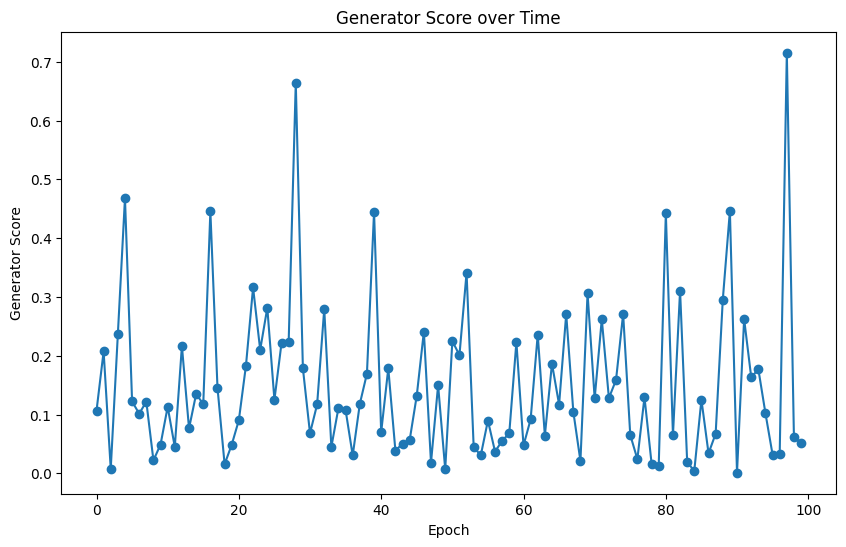

In [35]:
x = range(len(fake_scores))

plt.figure(figsize=(10,6))
plt.plot(x, fake_scores ,'-')
plt.scatter(x, fake_scores)
plt.xlabel('Epoch')
plt.ylabel('Generator Score')
plt.title('Generator Score over Time')
plt.show()

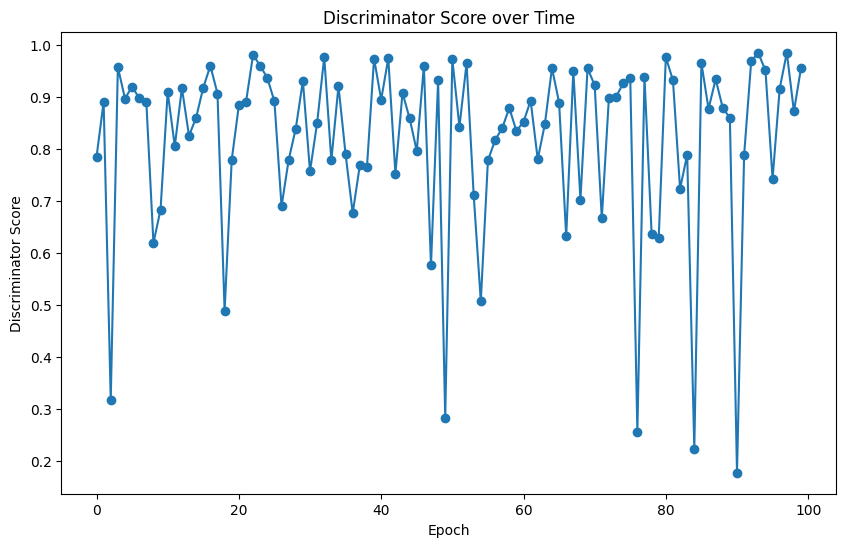

In [36]:
x = range(len(real_scores))

plt.figure(figsize=(10, 6))
plt.plot(x, real_scores ,'-')
plt.scatter(x, real_scores)
plt.xlabel('Epoch')
plt.ylabel('Discriminator Score')
plt.title('Discriminator Score over Time')
plt.show()

Text(0.5, 1.0, 'Losses')

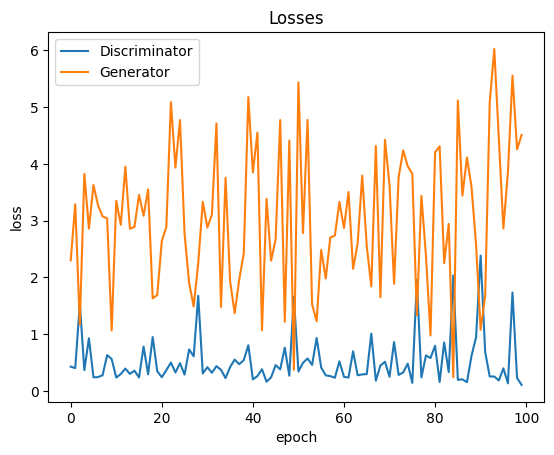

In [37]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

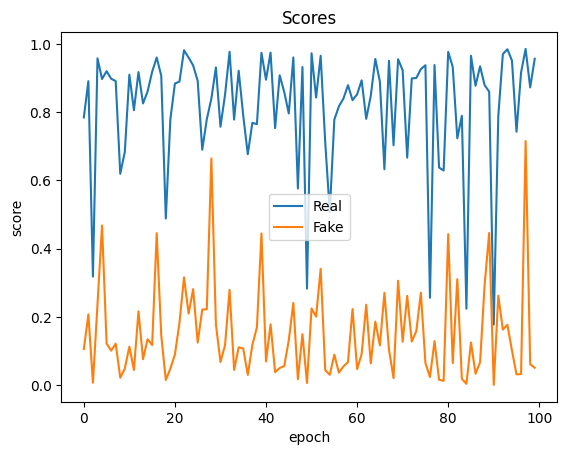

In [38]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

### 6. Image Generation

torch.Size([32, 3, 64, 64])


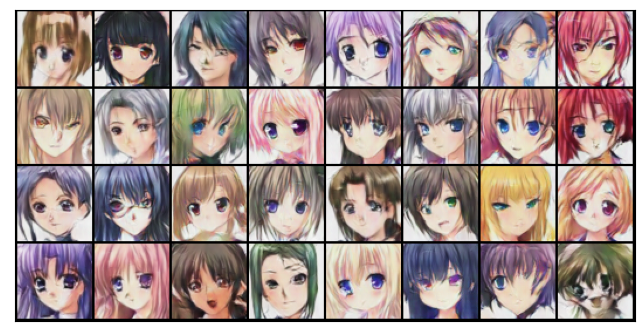

In [67]:
""" Generating Random Anime Faces using Trained Model."""

num = 32
xb = torch.randn(num, latent_dim, device = device) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)